In [1]:
def get_CNN_param(cnn_day, TAIEX_df, Triple_day , hasTurning_point, TAIEX_bias_df , isBias ,threshold =0.65) :
     
    def training (): 
        day = cnn_day
        df = TAIEX_df[::-1].reset_index(drop=True)
        ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)

        if isBias :        
            dropLabel = ['STOCK_ID','Date']
            #dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
        else :
            dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']

        if hasTurning_point : 
            turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
            start = 0 
            long_list = []
            long_label = []
            hasTurningPoint= []

            for i in turning_date:
                if start == 0 :
                    start = i[0]
                    continue
                if isBias :
                    split_data = TAIEX_bias_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
                else :
                    split_data = TAIEX_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
                long_list.extend(fn.get_series_data(split_data , day , False, isBias))
                long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
                start = i[0]
            long_list = np.array(long_list)
        else :
            if isBias : 
                df = TAIEX_bias_df[::-1].reset_index(drop=True)
                price_df = df.drop(dropLabel,axis=1)
            else :
                price_df = df.drop(dropLabel,axis=1)
            long_list = fn.get_series_data(price_df , day , False, isBias)
            long_label = ret.triple_barrier_signal[day-1:len(ret)]

        print(pd.Series(long_label).value_counts())
        balance= max(pd.Series(long_label).value_counts())/len(long_label)

    #     print(long_list , long_label)

        ## CNN Training by split data
        model, acc_list = cnn_training(long_list,long_label , day , 0.5 , 20 ,threshold)
        
        print("Param score: ", max(acc_list)/(balance**1.5) )
        
        return max(acc_list)/(balance**1.5)
    
    Triple_down_list = [0.98,0.975,0.97,0.965,0.96]
    Triple_up_list = [1.02,1.025,1.03,1.035,1.04,1.045,1.05]
    Triple_down = Triple_down_list[math.ceil(Triple_day**0.7)] ;
    
    score_list = []
    for Triple_up in Triple_up_list :        
        score_list.append(training())
    Triple_up = Triple_up_list[score_list.index(max(score_list))]
    
    score_list = []
    for Triple_down in Triple_down_list :        
        score_list.append(training())
    Triple_down = Triple_down_list[score_list.index(max(score_list))]
    
    print("best down:" ,Triple_down)
    print("best up:" ,Triple_up)
    
    return Triple_up, Triple_down

In [2]:
def get_CNN_cluster(cnn_day, TAIEX_df, Triple_up , Triple_down, Triple_day , num_cluster, hasTurning_point, TAIEX_bias_df , isBias ,threshold =0.45) :
    day = cnn_day
    df = TAIEX_df[::-1].reset_index(drop=True)
    ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)
    
    if isBias :        
        dropLabel = ['STOCK_ID','Date']
        #dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
    else :
        dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']
    
    if hasTurning_point : 
        turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
        start = 0 
        long_list = []
        long_label = []
        hasTurningPoint= []
        
        for i in turning_date:
            if start == 0 :
                start = i[0]
                continue
            if isBias :
                split_data = TAIEX_bias_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
            else :
                split_data = TAIEX_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
            long_list.extend(fn.get_series_data(split_data , day , False, isBias))
            long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
            start = i[0]
        long_list = np.array(long_list)
    else :
        if isBias : 
            df = TAIEX_bias_df[::-1].reset_index(drop=True)
            price_df = df.drop(dropLabel,axis=1)
        else :
            price_df = df.drop(dropLabel,axis=1)
        long_list = fn.get_series_data(price_df , day , False, isBias)
        long_label = ret.triple_barrier_signal[day-1:len(ret)]
        
    print(pd.Series(long_label).value_counts())
    
#     print(long_list , long_label)
        
    ## CNN Training by split data
    model, acc_list = fn.cnn_training(long_list,long_label , day , 0.5 , 30, threshold)

    if isBias : 
        df = TAIEX_bias_df[::-1].reset_index(drop=True)
        price_df = df.drop(dropLabel,axis=1)
    else :
        price_df = df.drop(dropLabel,axis=1)
    ## 取得CNN 最後一層的output
    flatten_list = []

    ## Ini all data
    long_list = fn.get_series_data(price_df , day , False , isBias)
    long_label = ret.triple_barrier_signal[day-1:len(ret)]
    long_label = long_label[::-1].reset_index(drop=True)
        
    predict_x=model.predict(long_list) 
    cnn_predict=np.argmax(predict_x,axis=-1)
    
    for periodData in long_list :
        keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
        activations = get_activations(model, keract_inputs)
        flatten_list.append(activations['Dense'])
    long_cluster_label = pd.Series(fn.get_cluster(flatten_list, num_cluster))
    print(long_cluster_label.value_counts())
    
    if isBias : 
        return long_cluster_label , long_label
    else :
        return long_cluster_label , long_label , cnn_predict
    


In [3]:

def cnn_training(allData, allLabel, day , splitsize, epoches = 100 , threshold = 0.45) :
    score = 0
    acc_list = []
    iter = 0
    while score < threshold and iter < 5:          
        week_list = allData
        week_label = allLabel
        # 定義梯度下降批量
        batch_size = 32
        # 定義分類數量
        num_classes = 3
        # 定義訓練週期
        epochs = epoches

        # 定義圖像寬、高
        img_rows, img_cols = day, 4
        input_shape = ( img_rows, img_cols)

        # 載入 MNIST 訓練資料
        split_ratio = splitsize
        x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
        x_test = week_list[ math.ceil(len(week_list)*split_ratio*0.4) : math.ceil(len(week_list)*split_ratio) ]

        y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
        y_test = week_label[ math.ceil(len(week_list)*split_ratio*0.4)  : math.ceil(len(week_label)*split_ratio) ]

        x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

        # x_train  = torch.from_numpy(x_train)
        # x_test  = torch.from_numpy(x_test)

        # y_train = torch.from_numpy(y_train)
        # y_test = torch.from_numpy(y_test)

        input_shape = (img_rows, img_cols,1 )

        # 保留原始資料，供 cross tab function 使用
        y_test_org = y_test


        # y 值轉成 one-hot encoding
        y_train = np_utils.to_categorical(y_train, num_classes)
        y_test = np_utils.to_categorical(y_test, num_classes)

        # 建立簡單的線性執行的模型
        model = Sequential()
        # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(16, kernel_size=(3,2),
                        activation='relu',
                        input_shape=input_shape))
        # 建立池化層，池化大小=2x2，取最大值
        #model.add(BatchNormalization())
        model.add(GaussianNoise(0.3))
        # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(32,  kernel_size=(3,2), activation='relu'))
        # 建立池化層，池化大小=2x2，取最大值
        model.add(AvgPool2D(pool_size=(3, 2)))
        # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
        model.add(Dropout(0.25))
        # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
        model.add(Flatten( name ='flatten'))
        # 全連接層: 128個output
        model.add(Dense(batch_size, 'sigmoid', name ='Dense'))
        # 使用 softmax activation function，將結果分類
        model.add(Dense(num_classes, activation='softmax' ))

        # 編譯: 選擇損失函數、優化方法及成效衡量方式
        model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer='adam',
                    metrics=['accuracy'])

        # 進行訓練, 訓練過程會存在 train_history 變數中
        train_history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=0,
                validation_data=(x_test, y_test))

        # 顯示損失函數、訓練成果(分數)
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score)
        print('Test accuracy:', score)
        acc_list.append(score[1])
        iter +=1
        score = score[1]
    return model, acc_list


In [4]:
import seaborn as sns
import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import cnn_feature_handler as fn
from keract import get_activations, display_activations

import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D,Conv2D, MaxPooling2D , AvgPool2D,AvgPool1D ,SeparableConv2D
import tensorflow as tf 
from keras.layers import GaussianNoise , BatchNormalization
from sklearn.cluster import KMeans


from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle
import random
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, KFold
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn import svm

In [8]:
9## read all data
path = "./Data/" 
allData = pd.read_csv(path+'Stock.csv')
allIndex = pd.read_csv(path+'model.csv')
columns = ['Date','Open','High','Low','Close','Volume'] 
#TAIEX_df.columns = columns
stock_list = pd.Series(allData.STOCK_ID, dtype="category").cat.categories.tolist()

index = 11

print("標的 : ",stock_list[index])
TAIEX_df = allData[allData.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)
TAIEX_Index = allIndex[allIndex.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)
df = TAIEX_df[::-1].reset_index(drop=True)
dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']
price_df = df.drop(dropLabel,axis=1)

標的 :  2603


 0    3026
 1    1501
-1     924
Name: triple_barrier_signal, dtype: int64
Test loss: [1.0055001974105835, 0.5467889904975891]
Test accuracy: [1.0055001974105835, 0.5467889904975891]
Test loss: [1.0045658349990845, 0.5467889904975891]
Test accuracy: [1.0045658349990845, 0.5467889904975891]
Test loss: [1.008074164390564, 0.5467889904975891]
Test accuracy: [1.008074164390564, 0.5467889904975891]
Test loss: [0.999095618724823, 0.5467889904975891]
Test accuracy: [0.999095618724823, 0.5467889904975891]
Test loss: [1.0010254383087158, 0.5467889904975891]
Test accuracy: [1.0010254383087158, 0.5467889904975891]
Param score:  1.3219975462203475
 0    3272
 1    1250
-1     929
Name: triple_barrier_signal, dtype: int64
Test loss: [0.9628843069076538, 0.5932721495628357]
Test accuracy: [0.9628843069076538, 0.5932721495628357]
Test loss: [0.9678241610527039, 0.5932721495628357]
Test accuracy: [0.9678241610527039, 0.5932721495628357]
Test loss: [0.9675008654594421, 0.5932721495628357]
Test accuracy

Test accuracy: [0.988669216632843, 0.5358744263648987]
Test accuracy: [0.98583984375, 0.5448430776596069]
Test accuracy: [0.9733003973960876, 0.5392376780509949]
Test accuracy: [0.9834614992141724, 0.5627802610397339]
best model with acc :  0.5627802610397339
1    2124
2    2096
0    1223
dtype: int64
5451 1    2354
0    1386
2    1101
3     610
dtype: int64
short cluster :  0
 1    484
-1    450
 0    448
Name: short, dtype: int64
got best cluster : 0
short cluster :  1
 0    1485
 1     442
-1     426
Name: short, dtype: int64
short cluster :  2
-1    387
 0    356
 1    355
Name: short, dtype: int64
short cluster :  3
 0    216
 1    199
-1    195
Name: short, dtype: int64
long cluster :  0
 0    428
-1    399
 1    396
Name: short, dtype: int64
long cluster :  1
 0    749
 1    718
-1    657
Name: short, dtype: int64
got best cluster in long: 1
long cluster :  2
 0    1328
-1     402
 1     366
Name: short, dtype: int64
label :  long
test date start form  20220106 to 20130705


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1: [0.21666667 0.46570397 0.2892562 ]
recall score(-1, 0, 1: [0.35616438 0.52016129 0.14344262]
training score : 1.0
testing score : 0.3385579937304075


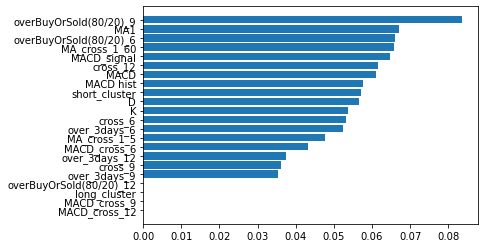

label :  short
test date start form  20220106 to 20130705


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1: [0.23376623 0.37128713 0.2109375 ]
recall score(-1, 0, 1: [0.43902439 0.32051282 0.1125    ]
training score : 1.0
testing score : 0.2727272727272727


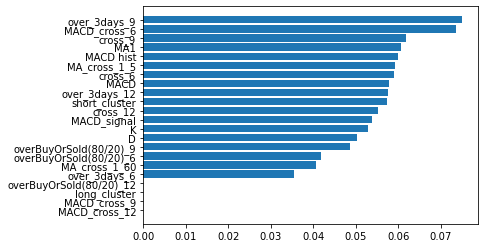

0.014978115804738098
profit :0.025 , loss:-0.01 , day :0 , out : -0.0008228725385479001, total_trade : 76
0.053830751988058534
profit :0.1 , loss:-0.02 , day :14 , out : 0.009937734857485194, total_trade : 41
 0    2467
 1    1917
-1    1067
Name: triple_barrier_signal, dtype: int64
Test loss: [1.061058521270752, 0.44648319482803345]
Test accuracy: [1.061058521270752, 0.44648319482803345]
Test loss: [1.0658820867538452, 0.44342508912086487]
Test accuracy: [1.0658820867538452, 0.44342508912086487]
Test loss: [1.0534683465957642, 0.44892966747283936]
Test accuracy: [1.0534683465957642, 0.44892966747283936]
Test loss: [1.0654070377349854, 0.44648319482803345]
Test accuracy: [1.0654070377349854, 0.44648319482803345]
Test loss: [1.067379355430603, 0.4458715617656708]
Test accuracy: [1.067379355430603, 0.4458715617656708]
Param score:  1.4744798959490069
 0    2720
 1    1651
-1    1080
Name: triple_barrier_signal, dtype: int64
Test loss: [1.0508736371994019, 0.49296635389328003]
Test accura

Test accuracy: [1.0633164644241333, 0.4282848536968231]
Test accuracy: [1.065601110458374, 0.42126378417015076]
Test accuracy: [1.0741724967956543, 0.43129387497901917]
Test accuracy: [1.065587043762207, 0.4353059232234955]
Test accuracy: [1.093017816543579, 0.42126378417015076]
Test accuracy: [1.1000282764434814, 0.4192577600479126]
Test accuracy: [1.0857312679290771, 0.42728185653686523]
Test accuracy: [1.1008858680725098, 0.4302908778190613]
Test accuracy: [1.090937614440918, 0.41123369336128235]
Test accuracy: [1.090656042098999, 0.4182547628879547]
Test accuracy: [1.0682239532470703, 0.4403209686279297]
Test accuracy: [1.0846045017242432, 0.39518555998802185]
Test accuracy: [1.0793216228485107, 0.44232699275016785]
Test accuracy: [1.0744619369506836, 0.43731194734573364]
Test accuracy: [1.0914890766143799, 0.42026078701019287]
Test accuracy: [1.088126540184021, 0.43229690194129944]
Test accuracy: [1.0718045234680176, 0.43129387497901917]
Test accuracy: [1.118563175201416, 0.404212

C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1: [0.18556701 0.17164179 0.47826087]
recall score(-1, 0, 1: [0.34615385 0.22772277 0.23109244]
training score : 1.0
testing score : 0.25733634311512416


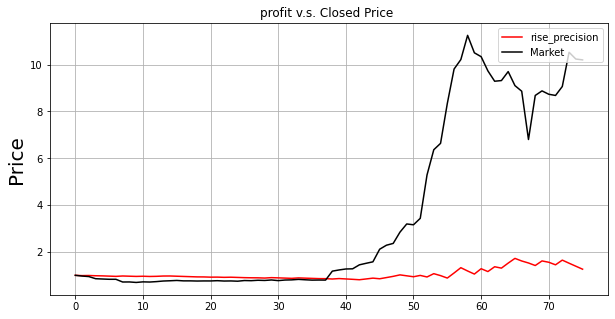

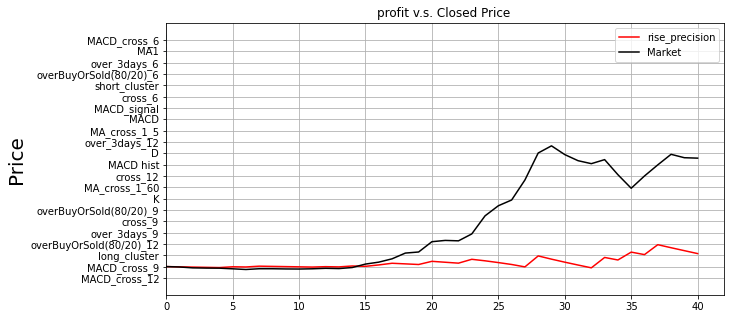

C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


label :  short
test date start form  20220106 to 20130306
precision(-1, 0, 1: [0.29931973 0.21818182 0.36170213]
recall score(-1, 0, 1: [0.67692308 0.14457831 0.14782609]
training score : 1.0
testing score : 0.30248306997742663


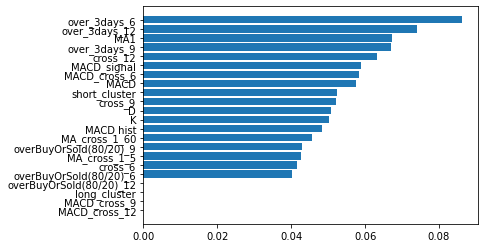

0.019652899321463056
profit :0.095 , loss:-0.02 , day :0 , out : -0.0043320891409518334, total_trade : 10
0.0545257300597669
profit :0.075 , loss:-0.035 , day :4 , out : 0.011993574314876864, total_trade : 10
 1    2187
 0    1953
-1    1311
Name: triple_barrier_signal, dtype: int64
Test loss: [1.0919532775878906, 0.4128440320491791]
Test accuracy: [1.0919532775878906, 0.4128440320491791]
Test loss: [1.0901654958724976, 0.38348624110221863]
Test accuracy: [1.0901654958724976, 0.38348624110221863]
Test loss: [1.0964422225952148, 0.3785932660102844]
Test accuracy: [1.0964422225952148, 0.3785932660102844]
Test loss: [1.0940439701080322, 0.37247705459594727]
Test accuracy: [1.0940439701080322, 0.37247705459594727]
Test loss: [1.0964436531066895, 0.37247705459594727]
Test accuracy: [1.0964436531066895, 0.37247705459594727]
Param score:  1.624527656920312
 0    2197
 1    1921
-1    1333
Name: triple_barrier_signal, dtype: int64
Test loss: [1.1075915098190308, 0.38837921619415283]
Test accur

KeyboardInterrupt: 

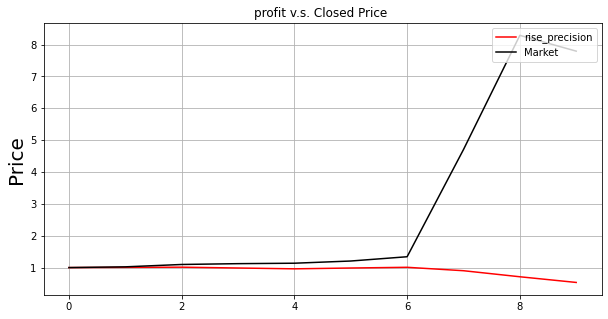

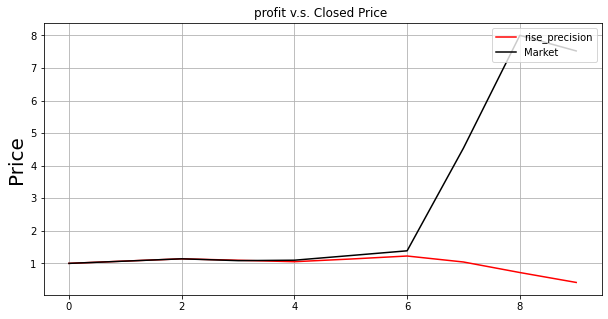

In [9]:
short_day_list = [2,3,4,5,6]
for short_day in short_day_list :
    
    Triple_up,Triple_down = get_CNN_param(8, TAIEX_df, short_day , False, [], False)

    short_cluster, short_label ,short_out= get_CNN_cluster(8, TAIEX_df, Triple_up, Triple_down, short_day , 4 , True, [], False,0.55)

    long_cluster , long_label, long_out = get_CNN_cluster(16, TAIEX_df, (Triple_up*2-1), (Triple_down*2-1), short_day*2, 3 , True, [], False,0.55)

    bias = False
    if bias : 
        allBiasData = pd.read_csv(path+'Windows5_test.csv')
        TAIEX_bias_df = allBiasData[allBiasData.STOCK_ID == stock_list[index]]
        TAIEX_bias_df = TAIEX_bias_df[TAIEX_bias_df.Date >= TAIEX_df.Date.min()]
        TAIEX_bias_df = TAIEX_bias_df[TAIEX_bias_df.Date <= TAIEX_df.Date.max()].reset_index(drop=True)

        # df = TAIEX_bias_df[::-1].reset_index(drop=True)
        # dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
        # price_df = df.drop(dropLabel,axis=1)

        long_bias_cluster , long_bias_label = get_CNN_cluster(20, TAIEX_df, 1.05, 0.97, 10, 4 , False, TAIEX_bias_df, True)
        short_bias_cluster, short_bias_label = get_CNN_cluster(8, TAIEX_df, 1.03, 0.98, 5 , 6 , False, TAIEX_bias_df, True)

    print (len(short_cluster), short_cluster.value_counts())
    short_cluster = short_cluster[:len(long_cluster)]
    short_out = short_out[:len(long_cluster)]
    if bias: 
        short_bias_cluster = short_bias_cluster[:len(long_cluster)]

    # read index

    Y = pd.DataFrame()
    Y['long'] = long_label.reset_index(drop = True)
    Y['short'] = short_label[:len(long_label)]

    X = TAIEX_Index[::-1].reset_index(drop=True)[:len(short_cluster)]
    X['date'] = X.Date
    X = X.drop(['Open','High','Low','Close','Volume','STOCK_ID','Date','MA5', 'MA10',  'MA20','MA60', 'MA120',
                'MA_cross_5_10','MA_cross_5_20','MA_cross_5_60','MA_cross_10_60','MA_cross_10_20','MA_cross_20_60','MA_cross_5_120'],axis = 1)
    #'pre5p0.1','pre5d0.1','pre3p0.05','pre3d0.05','pre1p0.03','pre1d0.03''開盤價', '最高價', '最低價', '收盤價', '成交股數', '證券代號',  '年前高', '季前高', '漲跌',
    #        '均漲天數', '均跌天數','MA60', 'RSI', 'MACD_signal','MACD','MA5', 'MA10',  'MA20', 'buy5', 'buy10',  'K', 'D',
    #         '實紅棒', '紅棒天線', '實黑棒', '黑棒天線', '上避雷針', '下避雷針', '連漲跌',
    #        'MACD_histogram', '日振幅', '波動率', 'MA交叉型態', 'KD交叉型態', 'KD交叉型態2',
    #        'MA5 slope', 'MA10 slope', 'MA60 slope', 'buy5 slope', 'buy10 slope',
    #        'MA5 acc', 'RSI5鈍化', 'D5', 'D60', 'D_upper_day', 'UD5', 'UD60',
    #        'UD前高壓力', 'UD波段壓立', '均線糾結1', '均線糾結2', '三陽開泰', '突破前高', '超漲跌','MACD_histogram', '日振幅', '波動率'
    # adding cluster
    X['long_cluster'] = long_cluster
    X['short_cluster'] = short_cluster

    # X['long_out'] = long_out
    # # X['short_out'] = short_out
    # X['long_bias_cluster'] = long_bias_cluster
    # X['short_bias_cluster'] = short_bias_cluster

    if bias:
        X['long_bias_cluster'] = long_bias_cluster
        X['short_bias_cluster'] = short_bias_cluster

    Y = Y[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
    X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]

    X


    from matplotlib import pyplot as plt
    def f_importances(coef, names):
        imp = coef
        imp,names = zip(*sorted(zip(imp,names)))
        plt.barh(range(len(names)), imp, align='center')
        plt.yticks(range(len(names)), names)
        plt.show()

    s_cluster = pd.Series(X.short_cluster, dtype="category").cat.categories.tolist()
    ratio = 0
    isShort = True
    for c in s_cluster : 
        print( "short cluster : ", c)
        print ( Y[X.short_cluster == c ].short.value_counts())
        ratio_ = (Y[X.short_cluster == c ].short.value_counts()[1])/len(Y[X.short_cluster == c ]) + (Y[X.short_cluster == c ].short.value_counts()[1])/Y[X.short_cluster == c ].short.value_counts()[-1]
        if ratio < ratio_:
            print("got best cluster :" , c)
            cluster = c
            ratio =  ratio_

    l_cluster = pd.Series(X.long_cluster, dtype="category").cat.categories.tolist()
    for c in l_cluster :
        print( "long cluster : ", c)
        print ( Y[X.long_cluster == c ].short.value_counts())    
        ratio_ = (Y[X.long_cluster == c ].short.value_counts()[1])/len(Y[X.long_cluster == c ]) + (Y[X.long_cluster == c ].short.value_counts()[1])/Y[X.long_cluster == c ].short.value_counts()[-1]
        if ratio < ratio_:
            isShort = False
            cluster = c
            print("got best cluster in long:" , cluster)
            ratio = ratio_

    if isShort :
        Y = Y[X.short_cluster.isin([cluster])].reset_index(drop=True)
        X = X[X.short_cluster.isin([cluster])].reset_index(drop=True)
    else : 
        Y = Y[X.long_cluster.isin([cluster])].reset_index(drop=True)
        X = X[X.long_cluster.isin([cluster])].reset_index(drop=True)

    label_ = ['long' , 'short']
    predict_ = pd.DataFrame()
    predict_test = pd.DataFrame()
    isFirst = True
    for label in label_ :
        test_ratio = 0.3
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :]

        X_test = testp.drop(['date'],axis = 1)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
#         ros = RandomOverSampler(random_state = 40)

#         X_train, y_train = ros.fit_resample(X_train, y_train)

        xgbc = XGBClassifier( booster='gbtree', max_depth=5,                
                      n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                      random_state=27,  tree_method='exact',
                      validate_parameters=1, verbosity=None)

        xgbc.fit(X_train,y_train)
        y_test_pred = xgbc.predict(X_test)
        y_train_pred = xgbc.predict(X_train)
        precision, recall, f1, _ = score(y_test, y_test_pred)


        print ( "precision(-1, 0, 1:" ,precision )    
        print ( "recall score(-1, 0, 1:" ,recall )
        print('training score :' , accuracy_score(y_train, y_train_pred))
        print('testing score :' , accuracy_score(y_test, y_test_pred))
        # feature important plot
        f_importances(xgbc.feature_importances_, X_train.columns)

        if isFirst :
            predict_['date'] = trainp.date
            isFirst = False

            predict_test['date'] = testp.date

        predict_[label] = y_train_pred
        predict_test[label] = y_test_pred


    # optimize by test
    selected = predict_test[::-1].reset_index(drop=True)
    selected = selected [:math.ceil(len(selected)/2)].reset_index(drop=True)

    selected

    days = [1,3,5,6,8,10,15]

    table = pd.DataFrame()
    p_table = []
    l_table = []
    d_table = []
    average = []

    for d in days :
        d = d-1
        if (d==0):
            profit = [0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.06,0.07,0.08,0.095] 
            loss = [0.01,0.015,0.02,0.025,0.035,0.045,0.055]
            fee = 0.0015+0.0029*0.3
        else :
            profit = [0.03,0.05,0.075,0.1,0.125,0.15] 
            loss = [0.02,0.035,0.05,0.075,0.1,0.15,0.2,0.25]
            fee = 0.003+0.0029*0.3

        for p in profit : 
            停利 = p
            for l in loss :
                停損 = l * -1

                進場日期 = []
                出場日期 = []
                進場價格 = []
                出場價格 = []
                獲利 = []
                for i in range(len(selected)):
                    if selected.short[i] > -1 and selected.long[i] > -1 :  
                        temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
                        if len(出場日期)>0 and selected.date[i] < 出場日期[-1] : 
                            continue
                        price = temp.Open[0]
                        進場價格.append(price)
                        進場日期.append(temp.Date[0])
                        for j in range(len(temp)):
                            if temp.High[j] > price *(1.00+停利) :
                                出場價格.append(price *(1+停利-fee))
                                出場日期.append(temp.Date[j])
                                break  
                            elif temp.Low[j] < price *(1 + 停損):
                                出場價格.append(price *(1+停損-fee))
                                出場日期.append(temp.Date[j])
                                break
                            elif j > d :
                                出場價格.append(temp.Close[j]*(1-fee))
                                出場日期.append(temp.Date[j])
                                break
                        獲利.append((出場價格[-1]/進場價格[-1])-1)

                績效表 = pd.DataFrame()
                績效表['進場日期'] = 進場日期
                績效表['出場日期'] = 出場日期
                績效表['進場價格'] = 進場價格
                績效表['出場價格'] = 出場價格
                績效表['獲利'] = 獲利

                p_table.append(p)
                l_table.append(l)
                d_table.append(d)
                average.append(sum(績效表.獲利) / (len(績效表)*((d+1))))

    table['p'] = p_table
    table['l'] = l_table
    table['d'] = d_table
    table['a'] = average

    table = table.sort_values(by=['a'],ascending=False).reset_index(drop = True)
    day_trade = table[table.d == 0].reset_index(drop=True)
    day_trade

    swing = table[table.d > 0].reset_index(drop=True)
    swing

    selected = predict_test[::-1].reset_index(drop=True)
    selected = selected [math.ceil(len(selected)/2):].reset_index(drop=True)
    selected
    
    import matplotlib.pyplot as plt
    def plot(outcome) : 
        fig,ax=plt.subplots(figsize=(10,5))
        ax.plot(outcome.accumulate/outcome.accumulate[0],color='red',label='rise_precision')
        ax.set_ylabel('profit',color='red',fontsize=20)
        ax.tick_params(axis='y',labelcolor='skyblue')
        plt.grid()
        ax.legend(loc='upper left')

        ax2=ax
        ax2.plot(outcome.出場價格/outcome.出場價格[0],color='black',label='Market')
        ax2.set_ylabel('Price',color='black',fontsize=20)
        ax2.tick_params(axis='y',labelcolor='black')
        ax2.legend(loc='upper right')

        plt.title('profit v.s. Closed Price ', color='black')
        plt.show()
        
    def estimate_return():
        進場日期 = []
        出場日期 = []
        進場價格 = []
        出場價格 = []
        獲利 = []
        accumulate = []
        for i in range(len(selected)-1):
            if selected.short[i] > -1 and selected.long[i] > -1 :
                if len(出場日期)>0 and selected.date[i] < 出場日期[-1] : 
                    continue
                temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
                price = temp.Open[0]
                進場價格.append(price)
                進場日期.append(temp.Date[0])
                flag = False
                for j in range(len(temp)):
                    if temp.High[j] > price *(1.00+停利) :
                        出場價格.append(price *(return_+停利))
                        出場日期.append(temp.Date[j])
                        break  
                    elif temp.Low[j] < price *(1 + 停損):
                        出場價格.append(price *(return_+停損))
                        出場日期.append(temp.Date[j])
                        break
                    elif j >= d :
                        出場價格.append(temp.Close[j]*return_)
                        出場日期.append(temp.Date[j])
                        break
                    elif j >= len(temp)-1:
                        出場價格.append(temp.Close[j]*return_)
                        出場日期.append(temp.Date[j])
                        break
                獲利.append((出場價格[-1]/進場價格[-1])-1)
                if len(accumulate) == 0 :
                    accumulate.append((出場價格[-1]))
                else :
                    accumulate.append(accumulate[-1] + (出場價格[-1] - 進場價格[-1]))
        績效表 = pd.DataFrame()
        績效表['進場日期'] = 進場日期
        績效表['出場日期'] = 出場日期
        績效表['進場價格'] = 進場價格
        績效表['出場價格'] = 出場價格
        績效表['獲利'] = 獲利
        績效表['accumulate'] = accumulate

        print(績效表.獲利.std())
        print( "profit :{} , loss:{} , day :{} , out : {}, total_trade : {}".format(停利,停損, d,  sum(績效表.獲利) / len(績效表),  len(績效表)))
        plot(績效表)
        
    index = 0
    for i in range(2):
        if i == 0:
            停利 = day_trade.p[index]
            停損 = day_trade.l[index]*-1
            d=day_trade.d[index]
        else :
            停利 = swing.p[index]
            停損 = swing.l[index]*-1
            d=swing.d[index]

        if (d==0):
            fee = 0.0015+0.0029*0.3
        else :
            fee = 0.003+0.0029*0.3
        return_ = 1-fee
        estimate_return()

